
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Bibliotecas para preparação dos dados
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Importação do dataset buscape
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [4]:
batch_01 = df

In [5]:
# Verificando quantidade de ratings
batch_01['rating'].value_counts()

rating
0    6810
1    6810
Name: count, dtype: int64

In [6]:
# Definindo documents e labels
documents = batch_01['review_text'].tolist()
labels = np.array(batch_01['rating'])

In [9]:
# Gerando tfidf matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
TFIDF_MATRIX = tfidf_vectorizer.fit_transform(documents)

In [10]:
# Definindo quantidade de folds para cross validation
KFOLD = KFold(n_splits=10, shuffle=True, random_state=42)
FOLD_ACCURACIES = []

In [11]:
DROPOUT = 0.05
LOSS = 'binary_crossentropy'
METRICS = ['acc']
EPOCHS = 5
BATCH_SIZE = 32
CALLBACKS=[EarlyStopping('loss', patience=3)]

In [12]:
for fold, (train_idx, test_idx) in enumerate(KFOLD.split(TFIDF_MATRIX), start=1):
    # Separando datasets
    X_train, X_test = TFIDF_MATRIX[train_idx], TFIDF_MATRIX[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Arquitetura MLP
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(DROPOUT)),
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilando o modelo
    LEARNING_RATE = 5e-4
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    # Treinando o modelo
    model_history = model.fit(
        X_train.toarray(),
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=1, 
        callbacks=CALLBACKS,
        validation_data=(X_test.toarray(), y_test)
    )
    
    # Avaliando o modelo
    predictions = (model.predict(X_test.toarray()) > 0.5).astype(int)
    
    FOLD_ACCURACY = accuracy_score(y_test, predictions)
    FOLD_ACCURACIES.append(FOLD_ACCURACY)
    
    print(f"Fold {fold}: Acuracia = {FOLD_ACCURACY:.2f}")

Epoch 1/5
384/384 [==============================] - 4s 9ms/step - loss: 0.5616 - acc: 0.7983 - val_loss: 0.4495 - val_acc: 0.8297
Epoch 2/5
384/384 [==============================] - 3s 9ms/step - loss: 0.3615 - acc: 0.8801 - val_loss: 0.3745 - val_acc: 0.8429
Epoch 3/5
384/384 [==============================] - 3s 8ms/step - loss: 0.2789 - acc: 0.9072 - val_loss: 0.3580 - val_acc: 0.8436
Epoch 4/5
384/384 [==============================] - 3s 8ms/step - loss: 0.2282 - acc: 0.9251 - val_loss: 0.3563 - val_acc: 0.8451
Epoch 5/5
43/43 [==============================] - 0s 2ms/step
Fold 1: Acuracia = 0.84
Epoch 1/5
384/384 [==============================] - 4s 8ms/step - loss: 0.5651 - acc: 0.8052 - val_loss: 0.4659 - val_acc: 0.8319
Epoch 2/5
384/384 [==============================] - 3s 9ms/step - loss: 0.3619 - acc: 0.8805 - val_loss: 0.3936 - val_acc: 0.8473
Epoch 3/5
384/384 [==============================] - 4s 10ms/step - loss: 0.2780 - acc: 0.9077 - val_loss: 0.3763 - val_acc: 0.

In [13]:
# Calculando average accuracy
avg_accuracy = np.mean(FOLD_ACCURACIES)
print(f"Average Accuracy: {avg_accuracy:.2f}")

Average Accuracy: 0.85


In [14]:
NB_START_EPOCHS = 5

In [15]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

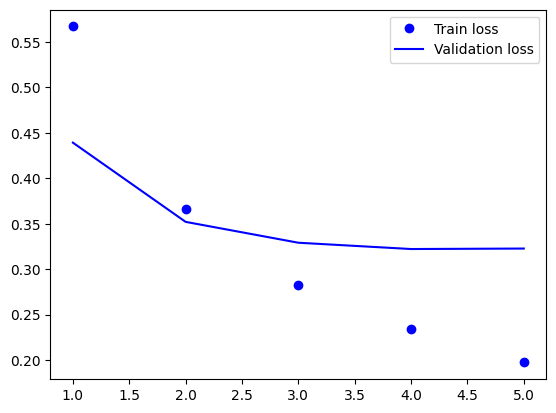

In [16]:
eval_metric(model_history, 'loss')

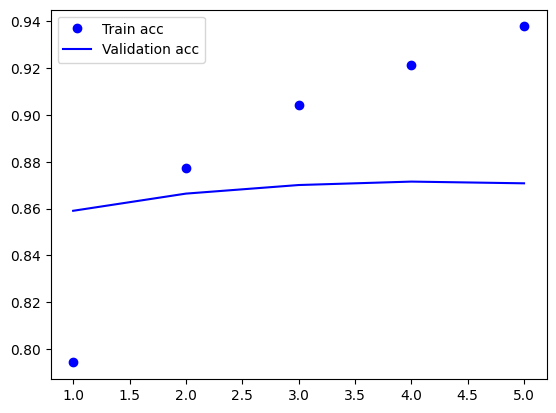

In [17]:
eval_metric(model_history, 'acc')

In [18]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

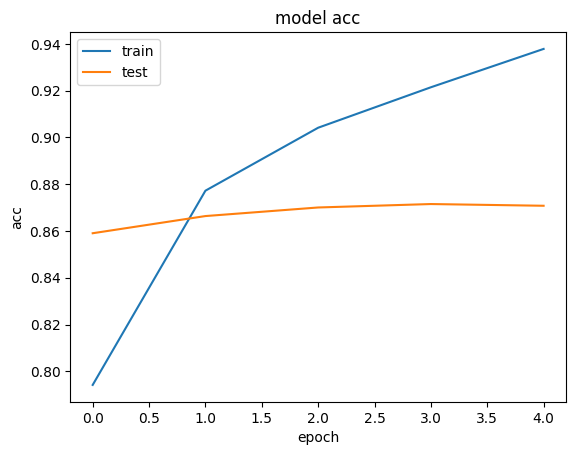

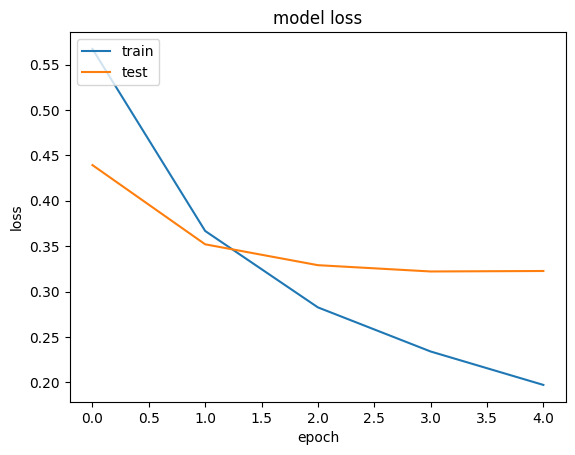

In [19]:
plot_eval_metrics(model_history, 'acc')
plot_eval_metrics(model_history, 'loss')